# Introduction to NeuralHydrology

**Before we start**

- This tutorial is rendered from a Jupyter notebook that is hosted on GitHub. If you want to run the code yourself, you can find the notebook and configuration files [here](https://github.com/neuralhydrology/neuralhydrology/tree/master/examples/01-Introduction).
- To be able to run this notebook locally, you need to download the publicly available CAMELS US rainfall-runoff dataset. See the [Data Prerequisites Tutorial](data-prerequisites.nblink) for a detailed description on where to download the data and how to structure your local dataset folder. You will also need to follow the [installation instructions](https://neuralhydrology.readthedocs.io/en/latest/usage/quickstart.html#installation) (the easiest option if you don't plan to implement your own models/datasets is `pip install neuralhydrology`; for other options refer to the installation instructions).

The Python package NeuralHydrology was was developed with a strong focus on research. The main application area is hydrology, however, in principle the code can be used with any data. To allow fast iteration of research ideas, we tried to develop the package as modular as possible so that new models, new data sets, new loss functions, new regularizations, new metrics etc. can be integrated with minor effort.

There are two different ways to use this package:

1. From the terminal, making use of some high-level entry points (such as `nh-run` and `nh-run-scheduler`)
2. From any other Python file or Jupyter Notebook, using NeuralHydrology's API

In this tutorial, we will give a very short overview of the two different modes.

Both approaches require a **configuration file**. These are `.yml` files which define the entire run configuration (such as data set, basins, data periods, model specifications, etc.). A full list of config arguments is listed in the [documentation](https://neuralhydrology.readthedocs.io/en/latest/usage/config.html) and we highly recommend to check this page and read the documentation carefully. There is a lot that you can do with this Python package and we can't cover everything in tutorials.

For every run that you start, a new folder will be created. This folder is used to store the model and optimizer checkpoints, train data means/stds (needed for scaling during inference), tensorboard log file (can be used to monitor and compare training runs visually), validation results (optionally) and training progress figures (optionally, e.g., model predictions and observations for _n_ random basins). During inference, the evaluation results will also be stored in this directory (e.g., test period results).


### TensorBoard logging
By default, the training progress is logged in TensorBoard files (add `log_tensorboard: False` to the config to disable TensorBoard logging). If you installed a Python environment from one of our environment files, you have TensorBoard already installed. If not, you can install TensorBoard with:

```
pip install tensorboard
``` 

To start the TensorBoard dashboard, run:

```
tensorboard --logdir /path/to/run-dir
```

You can also visualize multiple runs at once if you point the `--logdir` to the parent directory (useful for model intercomparison)

### File logging
In addition to TensorBoard, you will always find a file called `output.log` in the run directory. This file is a dump of the console output you see during training and evaluation.


## Using NeuralHydrology from the Terminal

### nh-run


Given a run configuration file, you can use the bash command `nh-run` to train/evaluate a model. To train a model, use


```bash
nh-run train --config-file path/to/config.yml
```

to evaluate the model after training, use

```bash
nh-run evaluate --run-dir path/to/run-directory
```

### nh-run-scheduler

If you want to train/evaluate multiple models on different GPUs, you can use the `nh-run-scheduler`. This tool automatically distributes runs across GPUs and starts a new one, whenever one run finishes.

Calling `nh-run-scheduler` in `train` mode will train one model for each `.yml` file in a directory (or its sub-directories).

```bash
nh-run-scheduler train --directory /path/to/config-dir --runs-per-gpu 2 --gpu_ids 0 1 2 3 
```
Use `-runs-per-gpu` to define the number of models that are simultaneously trained on a _single_ GPU (2 in this case) and `--gpu-ids` to define which GPUs will be used (numbers are ids according to nvidia-smi). In this example, 8 models will train simultaneously on 4 different GPUs.

Calling `nh-run-scheduler` in `evaluate` mode will evaluate all models in all run directories in a given root directory.

```bash
nh-run-scheduler evaluate --directory /path/to/parent-run-dir/ --runs-per-gpu 2 --gpu_ids 0 1 2 3 
```

## API usage

Besides the command line tools, you can also use the NeuralHydrology package just like any other Python package by importing its modules, classes, or functions.

This can be helpful for exploratory studies with trained models, but also if you want to use some of the functions or classes within a different codebase. 

Look at the [API Documentation](https://neuralhydrology.readthedocs.io/en/latest/api/neuralhydrology.html) for a full list of functions/classes you could use.

The following example shows how to train and evaluate a model via the API.

In [1]:
%load_ext autoreload
%autoreload 2
import os
from datetime import datetime

import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

# Check if GPUs are available
if torch.cuda.is_available():
    # Get the list of available GPUs
    gpus = list(range(torch.cuda.device_count()))

    # Set the device to use the second GPU (if available)
    try:
        torch.cuda.set_device(gpus[1])
    except RuntimeError as e:
        # Visible devices must be set at program startup
        print(e)

    # GPU check
    print("Num GPUs Available: ", len(gpus))

Matplotlib created a temporary cache directory at /tmp/matplotlib-1fq0xqfi because the default path (/staff/ame805/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


Num GPUs Available:  2


In [2]:
# echo $LD_LIBRARY_PATH
# Access the environment variable
print("LD_LIBRARY_PATH: ", os.environ.get("LD_LIBRARY_PATH"))

LD_LIBRARY_PATH:  /staff/ame805/.local/lib/python3.8/site-packages/nvidia/cudnn/lib:/usr/local/cuda-11.8/lib64


In [3]:
# Print torch version
print("Torch Version: ", torch.__version__)
# Print cuda version
print("Cuda Version: ", torch.version.cuda)
# Print cudaNN version
print("CudaNN Version: ", torch.backends.cudnn.version())

Torch Version:  2.1.0+cu121
Cuda Version:  12.1
CudaNN Version:  8902


### Train a model for a single config file

**Note**

- The config file assumes that the CAMELS US dataset is stored under `data/CAMELS_US` (relative to the main directory of this repository) or a symbolic link exists at this location. Make sure that this folder contains the required subdirectories `basin_mean_forcing`, `usgs_streamflow` and `camels_attributes_v2.0`. If your data is stored at a different location and you can't or don't want to create a symbolic link, you will need to change the `data_dir` argument in the `1_basin.yml` config file that is located in the same directory as this notebook.
- By default, the config (`1_basin.yml`) assumes that you have a CUDA-capable NVIDIA GPU (see config argument `device`). In case you don't have any or you have one but want to train on the CPU, you can either change the config argument to `device: cpu` or pass `gpu=-1` to the `start_run()` function.

In [4]:
basin_file = "1_basin.yml"
# basin_file = "1_basin_summa.yml"
# basin_file = "mclstm_run_config.yml"


# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path(f"{basin_file}"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("1_basin.yml"), gpu=-1)

2024-01-17 21:28:23,382: Logging to /home/ame805/neuralhydrology_fork/examples/01-Introduction/runs/test_run_1701_212823/output.log initialized.
2024-01-17 21:28:23,383: ### Folder structure created at /home/ame805/neuralhydrology_fork/examples/01-Introduction/runs/test_run_1701_212823
2024-01-17 21:28:23,384: ### Run configurations for test_run
2024-01-17 21:28:23,384: experiment_name: test_run
2024-01-17 21:28:23,385: train_basin_file: 1_basin.txt
2024-01-17 21:28:23,386: validation_basin_file: 1_basin.txt
2024-01-17 21:28:23,387: test_basin_file: 1_basin.txt
2024-01-17 21:28:23,387: train_start_date: 1999-10-01 00:00:00
2024-01-17 21:28:23,388: train_end_date: 2008-09-30 00:00:00
2024-01-17 21:28:23,389: validation_start_date: 1980-10-01 00:00:00
2024-01-17 21:28:23,390: validation_end_date: 1989-09-30 00:00:00
2024-01-17 21:28:23,391: test_start_date: 1989-10-01 00:00:00
2024-01-17 21:28:23,392: test_end_date: 1999-09-30 00:00:00
2024-01-17 21:28:23,392: device: cuda:0
2024-01-17 2

100%|██████████| 91/91 [00:17<00:00,  5.26it/s]
2024-01-17 21:28:40,950: Create lookup table and convert to pytorch tensor
100%|██████████| 91/91 [00:05<00:00, 17.23it/s]

 trainer.train_and_validate() 

# Epoch 1: 100%|██████████| 1169/1169 [00:23<00:00, 50.67it/s, Loss: 0.0356]
2024-01-17 21:29:14,038: Epoch 1 average loss: avg_loss: 0.13468, avg_total_loss: 0.13468
# Epoch 2: 100%|██████████| 1169/1169 [00:23<00:00, 50.65it/s, Loss: 0.1562]
2024-01-17 21:29:37,135: Epoch 2 average loss: avg_loss: 0.11118, avg_total_loss: 0.11118
# Epoch 3: 100%|██████████| 1169/1169 [00:22<00:00, 50.83it/s, Loss: 0.0845]
2024-01-17 21:30:00,149: Epoch 3 average loss: avg_loss: 0.10534, avg_total_loss: 0.10534
# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
2024-01-17 21:30:01,357: Epoch 3 average validation loss: 0.06625 -- Median validation metrics: avg_loss: 0.06625, NSE: 0.76076
# Epoch 4: 100%|██████████| 1169/1169 [00:23<00:00, 50.54it/s, Loss: 0.0611]
2024-01-17 21:30:24,498: Epoch

### Evaluate run on test set
The run directory that needs to be specified for evaluation is printed in the output log above. Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name. By default, it will use the same device as during the training process.

In [5]:
# Select the last folder in the 'runs' directory that matches the current date
run_files = sorted(os.listdir("runs"))
# Get the current date and format it as 'ddmm' (e.g., '0711' for November 7th)
current_date = datetime.now().strftime('%d%m')
# Filter filenames that match the current date

if basin_file == "1_basin.yml":
    filtered_run_files = sorted([filename for filename in run_files if len(filename.split('_'))>1 and filename.split('_')[2][:4] == current_date])
elif basin_file == "1_basin_summa.yml":
    filtered_run_files = sorted([filename for filename in run_files if len(filename.split('_'))>1 and filename.split('_')[3][:4] == current_date])

display(filtered_run_files)

# Ensure there are matching filenames for the current date
if filtered_run_files:
    # Sort the filtered filenames by timestamp in descending order
    # The latest filename for the current date is the last in the sorted list
    run_file = filtered_run_files[-1]

run_file


# run_file = "test_run_2710_133135"

['test_run_1701_134939',
 'test_run_1701_140444',
 'test_run_1701_142356',
 'test_run_1701_142704',
 'test_run_1701_142725',
 'test_run_1701_143424',
 'test_run_1701_143712',
 'test_run_1701_150329',
 'test_run_1701_154751',
 'test_run_1701_160935',
 'test_run_1701_161149',
 'test_run_1701_164126',
 'test_run_1701_173819',
 'test_run_1701_201222',
 'test_run_1701_212823']

'test_run_1701_212823'

In [6]:
run_dir = Path(f"runs/{run_file}")
eval_run(run_dir=run_dir, period="test")

2024-01-17 21:47:42,323: Using the model weights from runs/test_run_1701_212823/model_epoch050.pt
# Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

# Evaluation: 100%|██████████| 91/91 [00:27<00:00,  3.32it/s]
2024-01-17 21:48:09,769: Stored metrics at runs/test_run_1701_212823/test/model_epoch050/test_metrics.csv
2024-01-17 21:48:09,799: Stored results at runs/test_run_1701_212823/test/model_epoch050/test_results.p


### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [7]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['10396000', '12010000', '12013500', '12020000', '12025000', '12025700', '12035000', '12040500', '12041200', '12043000', '12048000', '12054000', '12056500', '12073500', '12082500', '12092000', '12095000', '12114500', '12115000', '12115500', '12117000', '12141300', '12143600', '12144000', '12145500', '12147500', '12147600', '12167000', '12175500', '12178100', '12186000', '12189500', '12358500', '12374250', '12375900', '12377150', '12381400', '12383500', '12388400', '12390700', '12411000', '12414500', '12447390', '12451000', '12488500', '13011500', '13011900', '13018300', '13023000', '13083000', '13161500', '13235000', '13240000', '13310700', '13313000', '13331500', '13337000', '13338500', '13340000', '13340600', '14020000', '14092750', '14096850', '14137000', '14138800', '14138870', '14138900', '14139800', '14141500', '14154500', '14158500', '14158790', '14166500', '14182500', '14185000', '14185900', '14187000', '14216500', '14222500', '14236200', '14301000', '14303200', '1430

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [22]:
### 01022500
### 01013500

# results['01022500']['1D']['xr']

ID = 10

if basin_file == "1_basin.yml":
    basin_txt = "1_basin.txt"
elif basin_file == "1_basin_summa.yml":
    basin_txt = "1_basin_summa.txt"

with open(basin_txt, "rb") as fp:
    hru_id = fp.read().splitlines()[ID].decode("utf-8")

results[hru_id]['1D']['xr']

<xarray.Dataset>
Dimensions:         (date: 3652, time_step: 1)
Coordinates:
  * date            (date) datetime64[ns] 1989-10-01 1989-10-02 ... 1999-09-30
  * time_step       (time_step) int64 0
Data variables:
    QObs(mm/d)_obs  (date, time_step) float32 0.5694 0.5694 ... 1.26 1.236
    QObs(mm/d)_sim  (date, time_step) float32 1.65 -1.467 -2.332 ... 2.249 2.269

Let's plot the model predictions vs. the observations

Text(0.5, 1.0, 'NeuralHydrology - Test period - NSE -2.914')

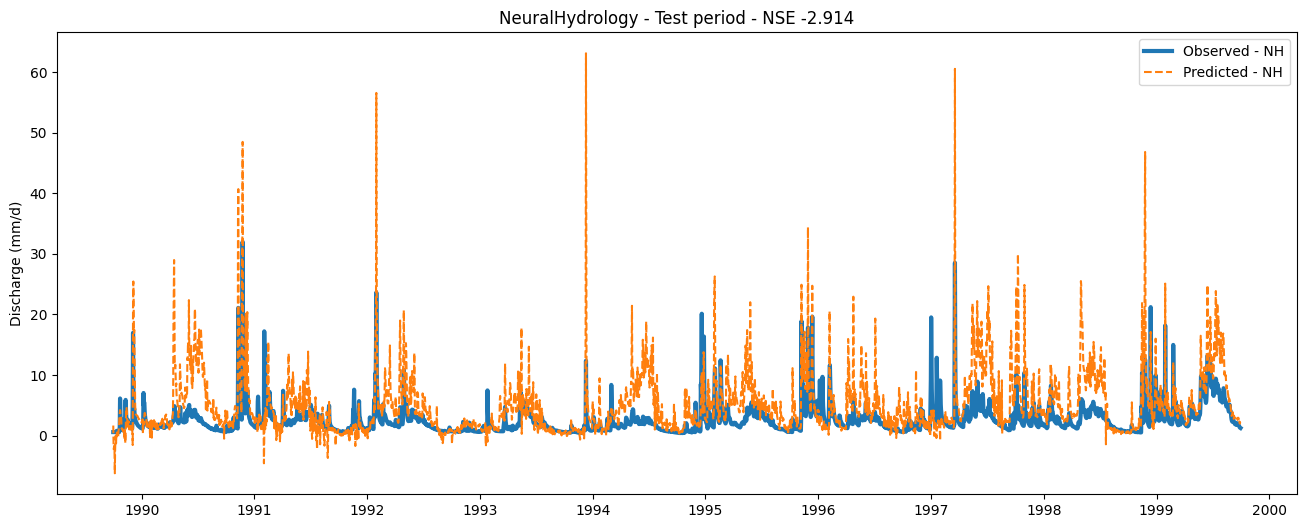

In [23]:
# extract observations and simulations
if basin_file == "1_basin.yml":
    target_obs = 'QObs(mm/d)_obs'
    target_sim = 'QObs(mm/d)_sim'
elif basin_file == "1_basin_summa.yml":
    target_obs = 'averageRoutedRunoff_obs'
    target_sim = 'averageRoutedRunoff_sim'


qobs = results[hru_id]['1D']['xr'][target_obs]
qsim = results[hru_id]['1D']['xr'][target_sim]

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(qobs['date'], qobs, linewidth=3, label='Observed - NH')
ax.plot(qsim['date'], qsim, '--', label='Predicted - NH')
ax.set_ylabel("Discharge (mm/d)")
plt.legend()
ax.set_title(f"NeuralHydrology - Test period - NSE {results[hru_id]['1D']['NSE']:.3f}")

In [24]:
import pandas as pd

# Assuming qobs.values and qsim.values are NumPy arrays
date_array = qobs['date'].values
qobs_array = qobs.values
qsim_array = qsim.values

# Create a DataFrame
df = pd.DataFrame({'date': date_array, 'qobs': qobs_array.flatten(), 'qsim': qsim_array.flatten()})

# Save the DataFrame to a CSV file
df.to_csv(f'NH_{hru_id}_test.csv', index=False)

In [25]:
date_array

array(['1989-10-01T00:00:00.000000000', '1989-10-02T00:00:00.000000000',
       '1989-10-03T00:00:00.000000000', ...,
       '1999-09-28T00:00:00.000000000', '1999-09-29T00:00:00.000000000',
       '1999-09-30T00:00:00.000000000'], dtype='datetime64[ns]')

Next, we are going to compute all metrics that are implemented in the NeuralHydrology package. You will find additional hydrological signatures implemented in `neuralhydrology.evaluation.signatures`.

$ \text{KGE} = 1 - \sqrt{[ s_r (r - 1)]^2 + [s_\alpha ( \alpha - 1)]^2 + 
            [s_\beta(\beta_{\text{KGE}} - 1)]^2}$

In [26]:
qobs

<xarray.DataArray 'QObs(mm/d)_obs' (date: 3652, time_step: 1)>
array([[0.5694423],
       [0.5694423],
       [0.5694423],
       ...,
       [1.302448 ],
       [1.2600429],
       [1.235811 ]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 1989-10-01 1989-10-02 ... 1999-09-30
  * time_step  (time_step) int64 0

In [27]:
values = metrics.calculate_all_metrics(qobs.isel(time_step=-1), qsim.isel(time_step=-1))
for key, val in values.items():
    print(f"{key}: {val:.3f}")

In [ ]:
print(f"NSE: {values['NSE']:.3f}")
print(f"MSE: {values['MSE']:.3f}")


NSE: 0.731
MSE: 46.694
